# **Innovators United - ACOUSTIC WAVE SENSORING**

We, the coding division of **Innovators United**, conducted an extensive search for relevant acoustic WAV data but were unable to find an exact match for our needs. However, we identified a cappuccino bird dataset that closely aligned with our requirements. We adapted this dataset to suit our project, customizing it to fit the specific objectives.

# Load Dependencis

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 2. Build Data Loading Function

## 2.1 Define Paths To Files ##

In [2]:
CAPUCHIN_FILE = os.path.join('data', '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips','XC114131-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')


## 2.1 Build Dataloading Function ##

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.2 Plot Wave ##

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

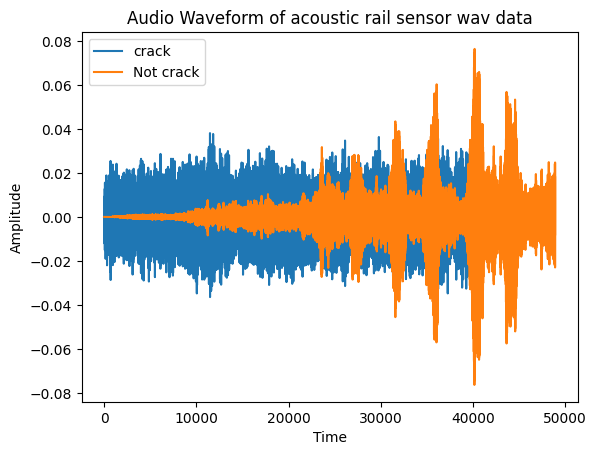

In [48]:
plt.plot(wave)
plt.plot(nwave)

plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend(['crack', 'Not crack'])
plt.title('Audio Waveform of acoustic rail sensor wav data')

plt.show()

# Create Tensorflow Dataset

## 3.1 Define paths to positive and negative data

In [6]:
POS = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips')
NEG = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips')

In [7]:
import os

pos_files = os.listdir(POS)
neg_files = os.listdir(NEG)

print("Positive files:", pos_files)
print("Negative files:", neg_files)


Positive files: ['XC27882-2.wav', 'XC227469-2.wav', 'XC456236-3.wav', 'XC227471-6.wav', 'XC227468-3.wav', 'XC513083-1.wav', 'XC216012-12.wav', 'XC9892-0.wav', 'XC27882-0.wav', 'XC227469-3.wav', 'XC433953-10.wav', 'XC79965-10.wav', 'XC526106-4.wav', 'XC46241-4.wav', 'XC600460-0.wav', 'XC201990-4.wav', 'XC388470-5.wav', 'XC114132-4.wav', 'XC227471-3.wav', 'XC9221-0.wav', 'XC433953-8.wav', 'XC46241-1.wav', 'XC178168-4.wav', 'XC216012-19.wav', 'XC395129-4.wav', 'XC227468-2.wav', 'XC46241-2.wav', 'XC216012-3.wav', 'XC216010-7.wav', 'XC216012-8.wav', 'XC65196-2.wav', 'XC3776-4.wav', 'XC3776-2.wav', 'XC526106-0.wav', 'XC456236-0.wav', 'XC3776-3.wav', 'XC114132-5.wav', 'XC27882-5.wav', 'XC178168-2.wav', 'XC79965-2.wav', 'XC307385-0.wav', 'XC600460-1.wav', 'XC9221-1.wav', 'XC433953-9.wav', 'XC16804-0.wav', 'XC178167-1.wav', 'XC388470-6.wav', 'XC456236-1.wav', 'XC22397-1.wav', 'XC216012-0.wav', 'XC216010-1.wav', 'XC227468-5.wav', 'XC216012-4.wav', 'XC433953-2.wav', 'XC16804-1.wav', 'XC114131-3.w

## 3.2 Create Tensorflow Datasets

In [8]:
pos = tf.data.Dataset.list_files(POS + '/*-*.wav')
neg = tf.data.Dataset.list_files(NEG + '/*-*.wav')


## 3.2 Add labels and combine positive and negative samples

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [10]:
data = positives.concatenate(negatives)

# 4. Determine Average Length of a capucin call

## 4.1 calculate wave cycle length

In [11]:
lengths = []
for file in os.listdir(os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips')):
    file_path = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips', file)
#     print("Current file path:", file_path)
    tensor_wave = load_wav_16k_mono(file_path)
    lengths.append(len(tensor_wave))


## 4.2 calculate mean, min  and max

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=49297>

In [13]:
tf.math.reduce_min(lengths)
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=63087>

# Build Preprocessing Function

## 5.1 Build Preprocessing Function

In [14]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test out the function and viz spectrogram

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [16]:
spectrogram, label = preprocess(filepath, label)

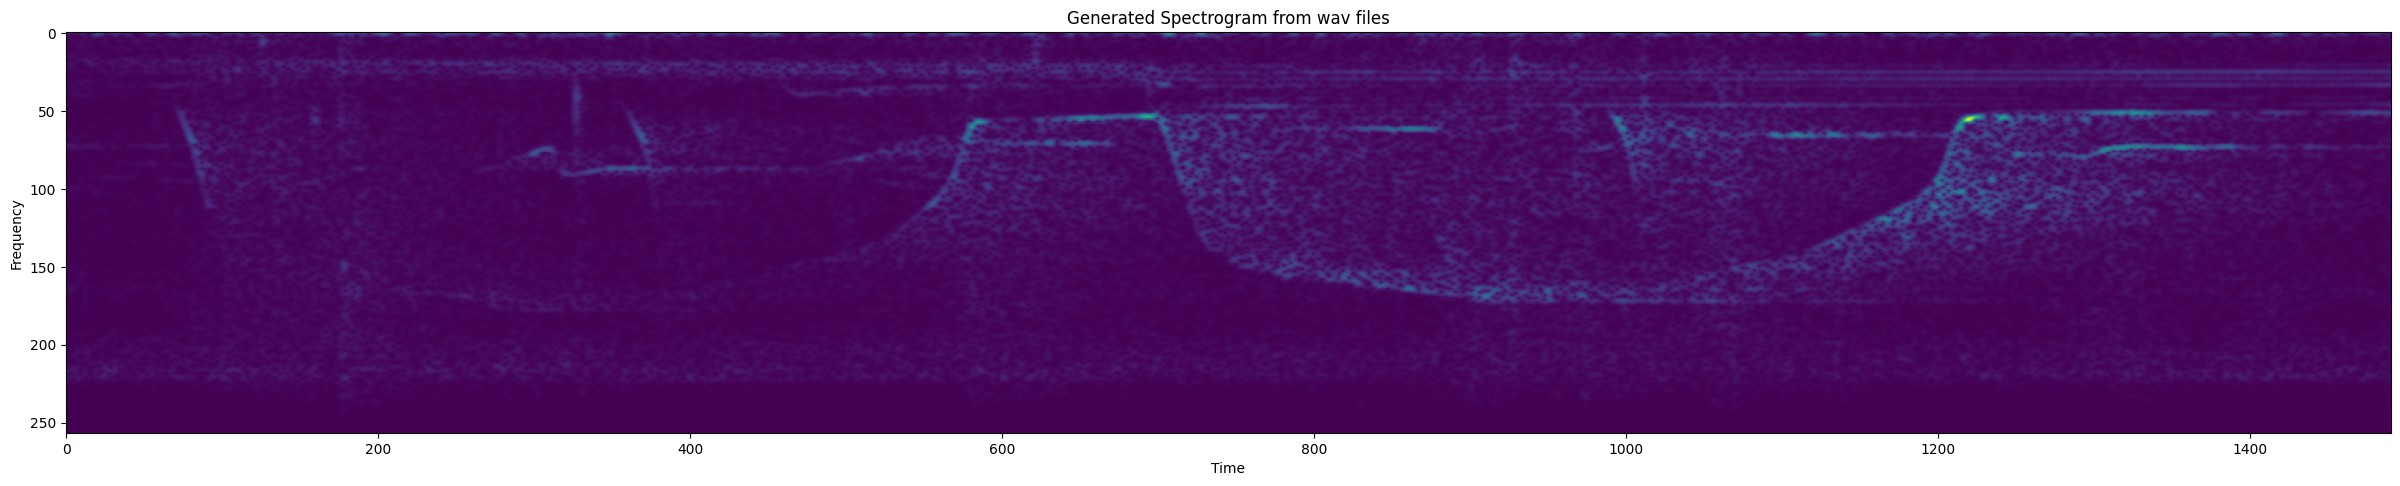

In [49]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])

plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Generated Spectrogram from wav files')

plt.show()

# Creating Training and Testing Partisions

## 6.1 create a tensorflow data pipeline

In [18]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size = 10000)
data = data.batch(16)
data = data.prefetch(8)

## 6.2 Split into Training and Testing Partitions ##

In [19]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test One Batch

In [20]:
samples, labels = train.as_numpy_iterator().next()

In [21]:
samples.shape

(16, 1491, 257, 1)

# Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout,BatchNormalization

## 7.2 Build Sequential Model, Compile and View Summary

In [23]:
model = Sequential()
model.add(Conv2D(16,(3,3),activation='relu', input_shape=(1491,257,1)))
model.add(Conv2D(16,(3,3),activation='relu'))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [25]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 1)                 6019377   
                                                                 
Total params: 6021857 (22.97 MB)
Trainable params: 6021857 (22.97 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Fit Model, View Loss and KPl Plots

In [27]:
history = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 8s 100ms/step - loss: 6.5245 - recall: 0.9125 - precision: 0.8343 - val_loss: 0.0283 - val_recall: 0.9800 - val_precision: 0.9800
Epoch 2/4
36/36 [==============================] - 3s 82ms/step - loss: 0.5616 - recall: 0.9686 - precision: 0.9625 - val_loss: 0.1594 - val_recall: 0.9434 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 3s 81ms/step - loss: 0.3636 - recall: 0.9684 - precision: 0.9808 - val_loss: 0.0359 - val_recall: 1.0000 - val_precision: 0.9844
Epoch 4/4
36/36 [==============================] - 3s 80ms/step - loss: 0.0346 - recall: 0.9934 - precision: 0.9934 - val_loss: 2.1958e-07 - val_recall: 1.0000 - val_precision: 1.0000


In [28]:
model.evaluate(test)

15/15 [==============================] - 0s 24ms/step - loss: 0.0086 - recall: 0.9859 - precision: 1.0000


[0.008559806272387505, 0.98591548204422, 1.0]

In [29]:
model.save('model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


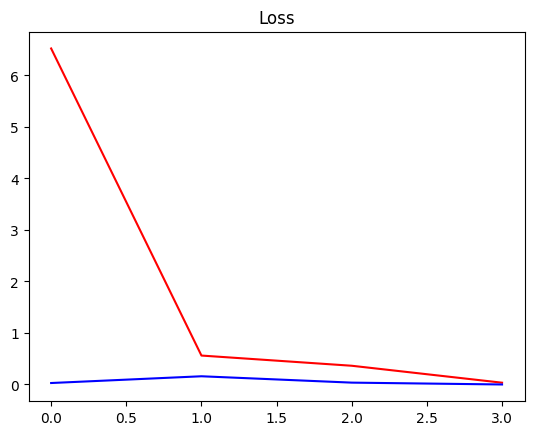

In [30]:
plt.title('Loss')
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'b')
plt.show()

# Make Prediction on single clip

## 8.1 get one batch and make prediction

In [31]:
xtest,ytest = test.as_numpy_iterator().next()

In [32]:
yhat = model.predict(xtest)

1/1 [==============================] - 0s 115ms/step


## Convert Logits to classes

In [33]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# Build Forest Parsing Function

## 9.1 load up mp3s

In [34]:
def load_mp3_16k_mono(filename):
    """ Load an MP3 file, convert it to a float tensor, and resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    
    # Convert to tensor and combine channels
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2
    
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    
    # Resample to 16 KHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    
    return wav


In [35]:
mp3 = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3')

In [36]:
wav = load_mp3_16k_mono(mp3)

In [37]:
audio_slice = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [38]:
sample, index = audio_slice.as_numpy_iterator().next()

## 9.2 Build Function to convert clips into windowed spectrogram

In [39]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

# 9.3 convert longer clips into windows and make predictions

In [40]:
audio_slice = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slice = audio_slice.map(preprocess_mp3)
audio_slice = audio_slice.batch(64)

In [41]:
yhat = model.predict(audio_slice)
yhat  = [ 1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 5s 893ms/step


## 9.4 Group Consenutive Detectons

In [42]:
from itertools import groupby
yhat = [ key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [43]:
calls

5

# 10 Make Prediction

## 10.1 Loop over all recordings and make prediction

In [44]:
results = {}
for file in os.listdir(os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings')):
    FILEPATH = os.path.join('data','/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings',file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    yhat = model.predict(audio_slices)
    results[file] = yhat

1/1 [==============================] - 1s 601ms/step


## Convert predictions into classes

In [45]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
# class_preds

## 10.3 Group Consective Detections

In [46]:
postprocessd = {}
for file, scores in class_preds.items():
    postprocessd[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessd

{'recording_76.mp3': 0,
 'recording_62.mp3': 0,
 'recording_48.mp3': 4,
 'recording_44.mp3': 1,
 'recording_45.mp3': 3,
 'recording_06.mp3': 5,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 5,
 'recording_17.mp3': 8,
 'recording_65.mp3': 5,
 'recording_74.mp3': 0,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 3,
 'recording_64.mp3': 3,
 'recording_39.mp3': 12,
 'recording_04.mp3': 4,
 'recording_28.mp3': 17,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 3,
 'recording_12.mp3': 0,
 'recording_59.mp3': 17,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 14,
 'recording_86.mp3': 14,
 'recording_47.mp3': 15,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 25,
 'recording_51.mp3': 3,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 3,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recordi

# 11 Export Results

In [47]:
import csv
with open('results.csv','w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recoding', 'capuchin_calls'])
    for key, value in postprocessd.items():
        writer.writerow([key, value])
    